#  EagleEye_v7 tutorial


We import necessary libraries and set up custom plot configurations for consistency.

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Directory setup for custom modules
import sys
module_path = '../../eagleeye'
sys.path.append(module_path)
import EagleEye_v7

# Custom plotting settings
sns.set(style="darkgrid")
plt.rcParams.update({
    'axes.titlesize': 21,
    'axes.labelsize': 17,
    'xtick.labelsize': 17,
    'ytick.labelsize': 17,
    'legend.fontsize': 17,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--',
    'grid.color': 'silver'
})


## 1. Generate the datasets 

In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Function to generate uniformly sampled 3D dataset
def generate_uniform_dataset(num_points):
    return np.random.uniform(-1, 1, size=(num_points, 3))

# Function to substitute points within a ball with new uniform samples
def substitute_within_ball(dataset, ball_center, ball_radius, substitution_prob=0.9):
    new_dataset = dataset.copy()
    for i, point in enumerate(dataset):
        if np.random.rand() < substitution_prob:
            if np.linalg.norm(point - ball_center) <= ball_radius:
                # Replace point with a new random uniform sample
                new_dataset[i] = np.random.uniform(-1, 1, size=3)
    return new_dataset

# Number of points
num_points = 50000

# Generate original uniform dataset
original_dataset = generate_uniform_dataset(num_points)

# Define ball center and radius
ball_center = np.array([0.0, 0.0, 0.0])
ball_radius = 0.2

# Generate dataset with points replaced within the ball
test_data = substitute_within_ball(original_dataset, ball_center, ball_radius)

reference_data = generate_uniform_dataset(num_points)



### 1.1 Visualize the generated datasets 

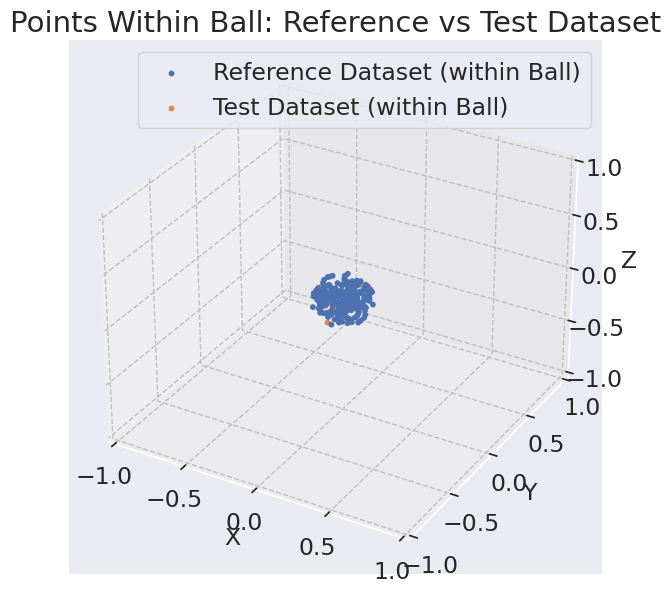

In [3]:

import matplotlib.pyplot as plt
# Function to identify points within the ball
def points_within_ball(dataset, ball_center, ball_radius):
    distances = np.linalg.norm(dataset - ball_center, axis=1)
    return dataset[distances <= ball_radius]

# Get points within the ball for both datasets
points_reference_ball = points_within_ball(reference_data, ball_center, ball_radius)
points_test_ball = points_within_ball(test_data, ball_center, ball_radius)

# Plotting the points within the ball for both datasets
fig = plt.figure(figsize=(12, 6))

# Create a 3D axis for plotting
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for points within the ball in reference dataset
ax.scatter(points_reference_ball[:, 0], points_reference_ball[:, 1], points_reference_ball[:, 2], s=10, alpha=1, label="Reference Dataset (within Ball)")

# Scatter plot for points within the ball in test dataset
ax.scatter(points_test_ball[:, 0], points_test_ball[:, 1], points_test_ball[:, 2], s=10, alpha=1, label="Test Dataset (within Ball)")

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("Points Within Ball: Reference vs Test Dataset")

# Display legend
ax.legend()

# Display the plot
plt.tight_layout()
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
plt.show()


In [4]:
points_reference_ball.shape

(228, 3)

## 2. EagleEye_v7

Reference dataset: $\mathbf{X}$

Test dataset:      $\mathbf{Y}$ 

Define: $\mathbf{U} = \mathbf{X} \cup \mathbf{Y}$

COMPUTE: $\forall i\in U,$  $\Upsilon_i $ whith Inject validation for the data belonging to $\mathbf{X}$ 

Revert the order of Reference and Test to get $\forall j\in U,$  $\Upsilon_{j}(rev) $ whith Inject validation for the data belonging to $\mathbf{Y}$ 

In [5]:
K_M                   = 500
CRITICAL_QUANTILES    = [ 1-1E-5, 1-1E-6 ]
VALIDATION            = reference_data.shape[0]


NUM_CORES             = 10

result_dictionary     = EagleEye_v7.Soar(
    reference_data, test_data, result_dict_in = {}, K_M = K_M, critical_quantiles = CRITICAL_QUANTILES,
    num_cores=NUM_CORES, validation=VALIDATION, partition_size=100 )



Eagle...Soar!

                               /T /I
                              / |/ | .-~/
                          T\ Y  I  |/  /  _
         /T               | \I  |  I  Y.-~/
        I l   /I       T\ |  |  l  |  T  /
     T\ |  \ Y l  /T   | \I  l   \ `  l Y
 __  | \l   \l  \I l __l  l   \   `  _. |
 \ ~-l  `\   `\  \  \ ~\  \   `. .-~   |
  \   ~-. "-.  `  \  ^._ ^. "-.  /  \   |
.--~-._  ~-  `  _  ~-_.-"-." ._ /._ ." ./
 &gt;--.  ~-.   ._  ~&gt;-"    "\   7   7   ]
^.___~"--._    ~-{  .-~ .  `\ Y . /    |
 &lt;__ ~"-.  ~       /_/   \   \I  Y   : |
   ^-.__           ~(_/   \   &gt;._:   | l______
       ^--.,___.-~"  /_/   !  `-.~"--l_ /     ~"-.
              (_/ .  ~(   /'     "~"--,Y   -=b-. _)
               (_/ .  \  :           / l      c"~o \
                \ /    `.    .     .^   \_.-~"~--.  )
                 (_/ .   `  /     /       !       )/
                  / / _.   '.   .':      /        '
                  ~(_/ .   /    _  `  .-&lt;_
                    /_/ 

#### Overdensities test_set:
result_dictionary['stats']['Upsilon_i_plus'] : $\Upsilon_i, i\in \mathbf{Y} $ 

#### Underdensities reference_set:
result_dictionary['stats']['Upsilon_i_Val_plus'] : $\Upsilon_i, i\in \mathbf{X} $ (the IV one)

#### Overdensities reference_set:
result_dictionary['stats_reverse']['Upsilon_i_plus'] : $\Upsilon_j(rev), j\in \mathbf{X} $ 

#### Underdensities test_set:
result_dictionary['stats_reverse']['Upsilon_i_Val_plus'] : $\Upsilon_j(rev), j\in \mathbf{Y} $ (the IV one)

### 2.1 Visualize the putative anomalous points

Plot values marked as putative anomalies. 

The overdensities within the test dataset are colored based on their $\Upsilon_i $ with red cmap.

The overdensities within the reference dataset are colored based on their $\Upsilon_i(rev) $ with blue cmap.


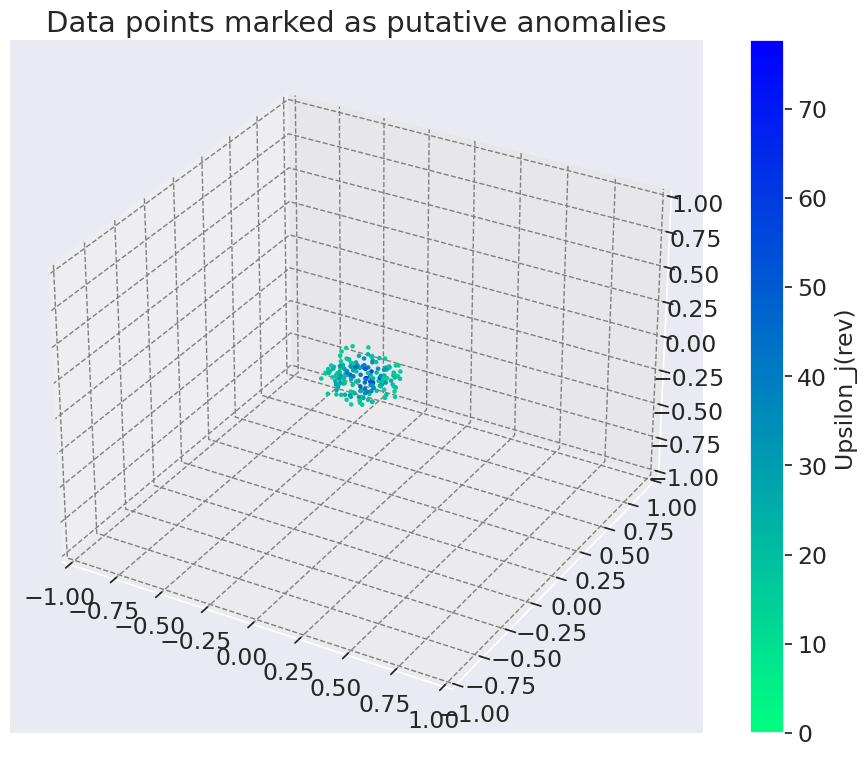

In [6]:
from utils_37 import     plot_data_points_marked_as_putative_anomalies


#plot_data_points_marked_as_putative_anomalies(test_data, reference_data, result_dictionary )
title="Data points marked as putative anomalies"
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')



# Indices for over-threshold in reference_data (reverse logic)
idx_plot2 = (result_dictionary['stats_reverse']['Upsilon_i_plus'] >= result_dictionary['Upsilon_star_minus'][0])
sc2 = ax.scatter(
    reference_data[idx_plot2, 0],
    reference_data[idx_plot2, 1],
    reference_data[idx_plot2, 2],
    cmap='winter_r',
    c=result_dictionary['stats_reverse']['Upsilon_i_plus'][idx_plot2],
    alpha=1,
    s=5,
    vmin=0
)
colorbar2 = fig.colorbar(sc2, ax=ax)
colorbar2.set_label('Upsilon_j(rev)')

# Fixed axis limits
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

ax.set_title(title)
plt.show()


## 3 Iterative Equalization

Pipeline for
#### Overdensities test_set:
result_dictionary['stats']['Upsilon_i_plus'] : $\Upsilon_i, i\in \mathbf{Y}$; 

1) While $\exists i \in \mathbf{Y}$ such that $\Upsilon_i \geq \Upsilon_*$;

2) Identify the index $i_{max}$ such that maximize $\Upsilon_{i_{max}} = \max_{i\in \mathbf{Y}}{\Upsilon_i}$;

3) Remove $i_{\text{max}}$ and its nearest neighbours up to the next $\mathbf{X}$ data point from the set $\mathbf{Y}$. Store all removed points in a new set $\mathbf{W_o}$. Update the set $\mathbf{U} = \mathbf{U} \setminus \mathbf{W_o}$;

4)  Recompute $\Upsilon_i, i\in \mathbf{Y}$ for the remaining points in $\mathbf{Y}$ that still exceed $\Upsilon_*$, restricting the nearest-neighbour search to updated $\mathbf{U}$ that do not include points in $\mathbf{W_o}$.

5) Return to point 1)

Pipeline for
#### Overdensities reference_set:
result_dictionary['stats_reverse']['Upsilon_i_plus'] : $\Upsilon_j(rev), j\in \mathbf{X} $ 

1) While $\exists j \in \mathbf{X}$ such that $\Upsilon_j(rev) \geq \Upsilon_*$;

2) Identify the index $j_{max}$ such that maximize $\Upsilon_{j_{max}}(rev) = \max_{j\in \mathbf{X}}{\Upsilon_j}(rev)$;

3) Remove $j_{\text{max}}$ and its nearest neighbours up to the next $\mathbf{Y}$ data point from the set $\mathbf{X}$. Store all removed points in a new set $\mathbf{W_u}$. Update the set $\mathbf{U} = \mathbf{U} \setminus \mathbf{W_u}$; 

4)  Recompute $\Upsilon_j(rev), j\in \mathbf{X}$ for the remaining points in $\mathbf{X}$ that still exceed $\Upsilon_*$, restricting the nearest-neighbour search to updated $\mathbf{U}$ that do not include points in $\mathbf{W_u}$.

5) Return to point 1)




### 3.1 Visualize $\mathbf{W_o}$ and $\mathbf{W_u}$

Plot values marked extracted by iterative equalization. 

The overdensities within the test dataset $\mathbf{W_o}$ are colored in red.

The overdensities within the reference dataset $\mathbf{W_u}$ are colored blue.


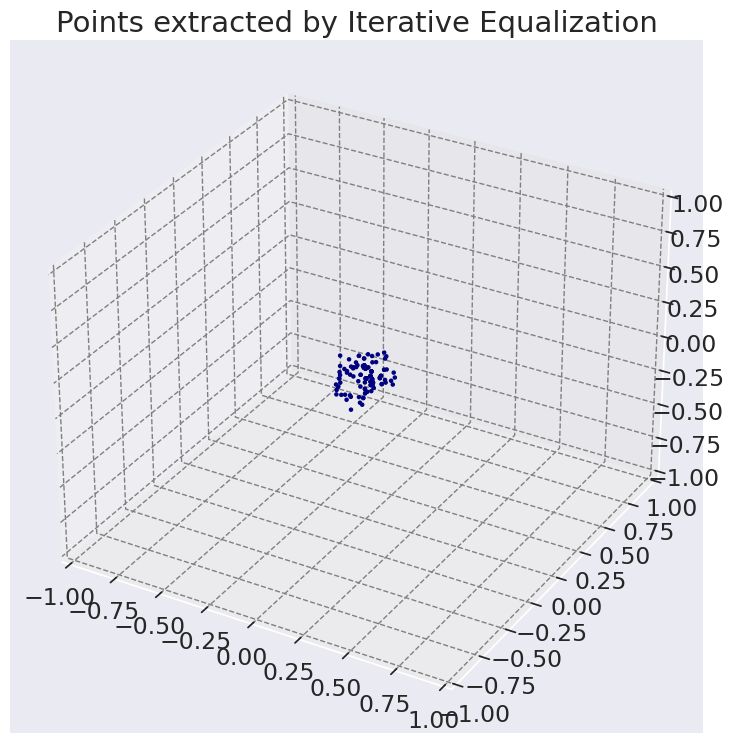

In [7]:
title="Points extracted by Iterative Equalization"
threshold = CRITICAL_QUANTILES[0]
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

under_idx = result_dictionary['underdensities'][threshold] # indices in reference_data

ax.scatter(
    reference_data[under_idx, 0],
    reference_data[under_idx, 1],
    reference_data[under_idx, 2],
    c='navy',
    alpha=1,
    s=5
)

# Fixed axis limits
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)

plt.title(title)
plt.show()


## 4 Clustering and aggregating

In order to get statistics from our computaitons let us partition the datapoints such that $\Upsilon_i, i\in \mathbf{Y}$ and $\Upsilon_j(res), j\in \mathbf{X}$ that were inititaly greater then $\Upsilon_*$:

#### Overdensities test_set:
result_dictionary['stats']['Upsilon_i_plus'] : $\Upsilon_i, i\in \mathbf{Y} $ 

#### Overdensities reference_set:
result_dictionary['stats_reverse']['Upsilon_i_plus'] : $\Upsilon_j(rev), j\in \mathbf{X} $ 



### 4.1 Intersect the thus obtained clusters with $\mathbf{W_o}$ and $\mathbf{W_u}$

#### 4.1.1 Overdensities test:

##### 1) Within each overdensity cluster identify the $i_{loc}$ such that $\Upsilon_{i_{loc}} = \min_{i \in \mathbf{W_o}}\Upsilon_{i} $

##### 2) Within each overdensity cluster keep all points such that $\Upsilon_{i} >= \Upsilon_{i_{loc}}, i\in \mathbf{U}$.


##### 3) Get the desired statistics by separatelly considering those comming fom \mathbf{X} (background whithin that cluster) and those comming from \mathbf{Y}.


#### 4.1.2 :Overdensities reference (underdensities):

##### 1) Within each overdensity cluster identify the $j_{loc}$ such that $\Upsilon_{j_{loc}}(rev) = \min_{j \in \mathbf{W_u}}\Upsilon_{j}(rev) $

##### 2) Within each overdensity cluster keep all points such that $\Upsilon_{j}(rev) >= \Upsilon_{j_{loc}}(rev), j\in \mathbf{U}$.


##### 3) Get the desired statistics by separatelly considering those comming fom \mathbf{Y} (test underdensities belonging to that cluster) and those comming from \mathbf{X}.


In [8]:
#%% # Clustering
qt=0
clusters = EagleEye_v7.partitian_function(reference_data,test_data,result_dictionary,result_dictionary['Upsilon_star_plus'][qt], result_dictionary['Upsilon_star_minus'][qt],K_M=K_M)

#clusters_plus,clusters_minus = clusters



Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fb9fb894540>
Traceback (most recent call last):
  File "/u/s/sspringe/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/u/s/sspringe/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/u/s/sspringe/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/u/s/sspringe/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no 

Computation of distances started
Computation of the distances up to 196 NNs started
0.42 seconds for computing distances
ID estimation finished: selecting ID of [2.67]
kstar estimation started, Dthr = 23.92812698
0.00 seconds computing kstar
kstar-NN density estimation started
k-NN density estimation finished
Clustering started
init succeded
Raw identification of the putative centers:  0.000 sec
Further checking on centers:  0.000 sec 
Pruning of the centers wrongly identified in part one:  0.000 sec
Preliminary assignation finished:  0.000 sec
('Number of clusters before multimodality test=', 2)
Identification of the saddle points:  0.000 sec
Multimodality test finished:  0.000 sec
Final operations: 2.7418136596679688e-05 sec
Clustering finished, 1 clusters found
total time is, 0.0008237361907958984


In [9]:
clusters_plus,clusters_minus = clusters
clusters_minus

[array([ 3316,  3552,  4448,  5735,  6462,  7682,  7717,  8200,  8800,
         8910, 11444, 13517, 15295, 16938, 17319, 19452, 20030, 20729,
        23020, 24688, 25328, 28665, 31355, 31701, 38316, 42334, 43953,
        49140, 50036, 50532, 51270, 51430, 51750, 52024, 52380, 52684,
        52747, 52898, 53192, 53617, 53826, 53889, 54205, 54708, 54768,
        55268, 55664, 56082, 56168, 56312, 56824, 57304, 58055, 58571,
        58950, 60447, 60697, 61222, 61226, 61518, 61839, 62126, 62230,
        62977, 63019, 63290, 63473, 63727, 63949, 64415, 64467, 65137,
        65622, 65879, 66501, 66764, 67008, 67079, 67885, 67945, 68100,
        68631, 68988, 69083, 69579, 69585, 70097, 70235, 70623, 70907,
        70928, 70980, 71196, 71238, 71533, 71557, 71581, 71985, 72115,
        72137, 72284, 72539, 72586, 72798, 72936, 73474, 73690, 73777,
        73800, 74400, 74545, 74631, 75833, 76340, 76467, 76474, 77799,
        77871, 78182, 78340, 78440, 78717, 79273, 80163, 81043, 81297,
      

In [10]:
#%% # Creation of the dictionaries
IV_IE_dict = EagleEye_v7.IV_IE_get_dict(clusters,result_dictionary,[CRITICAL_QUANTILES[qt]],test_data,reference_data)



Number of clusters:  1
Cluster number  1
Number of clusters:  1


#### Structure of the dictionary containing the results
    IV_IE_dict = {
    "OVER_clusters": {
        i: {"IE_extra": None, "From_test": None, "From_ref": None}
        for i in range(len(clusters_plus))
    },
    "UNDER_clusters": {
        i: {"IE_extra": None, "From_test": None, "From_ref": None}
        for i in range(len(clusters_minus))
    }
    }

### 4.2 Visualize Clustered Overdensities and Underdensities 

#### 4.2.1 Clustering of points removed by itarative equalization

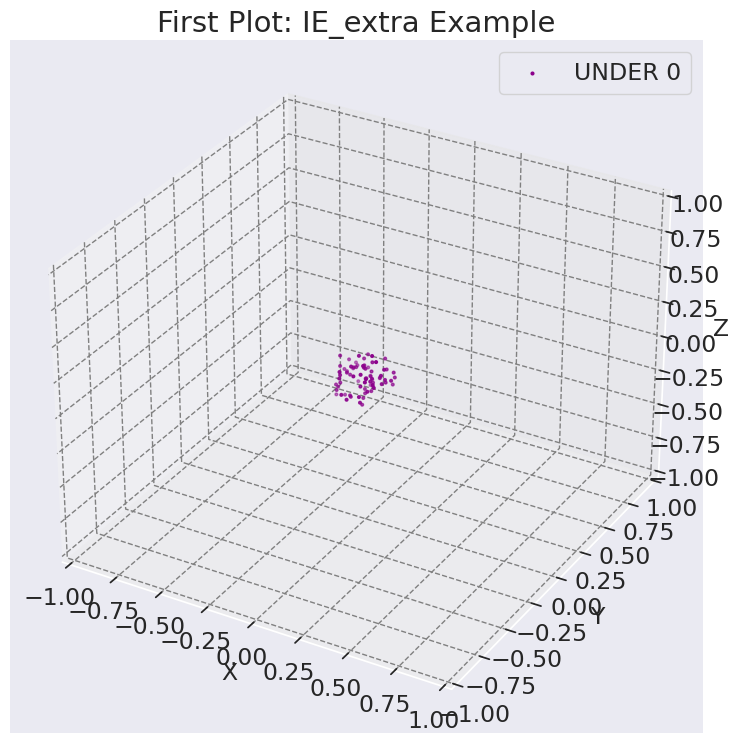

In [11]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

under_clusters = IV_IE_dict["UNDER_clusters"]


# UNDER
for idx, (i, cluster_data) in enumerate(under_clusters.items()):
    row_indices = cluster_data["IE_extra"]
    xs, ys, zs = [], [], []
    for ridx in row_indices:
        x, y, z = reference_data[ridx]
        xs.append(x); ys.append(y); zs.append(z)
    ax.scatter(xs, ys, zs, c='darkmagenta', marker='.',s=15, label=f"UNDER {i}" if idx==0 else "")

ax.set_title("First Plot: IE_extra Example")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
ax.legend()
plt.show()


#### 4.2.2 Clustering of aggregaed Overdensities wrt test data ( shades of reds ) and reference data (shades of blus)

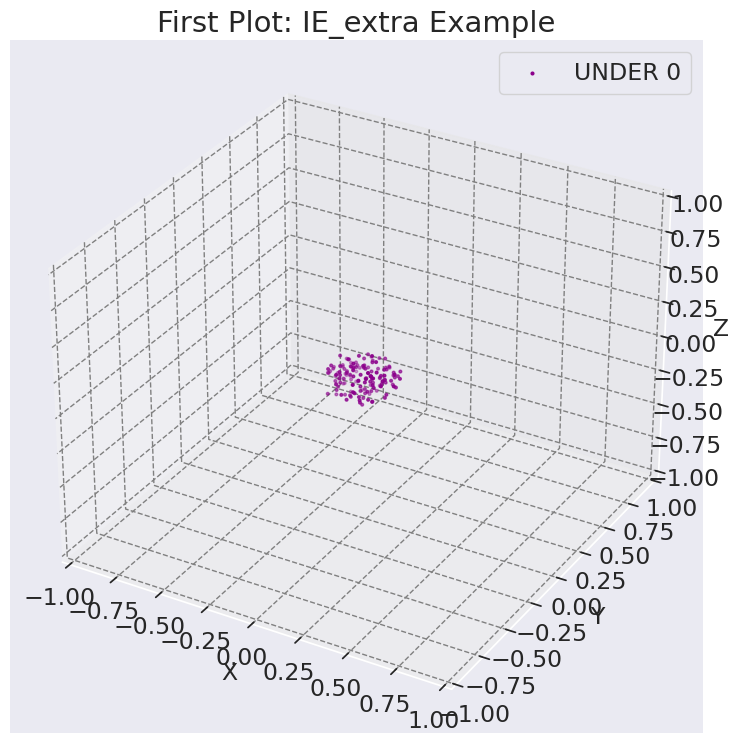

In [12]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

under_clusters = IV_IE_dict["UNDER_clusters"]


# UNDER
for idx, (i, cluster_data) in enumerate(under_clusters.items()):
    row_indices = cluster_data["From_ref"]
    xs, ys, zs = [], [], []
    for ridx in row_indices:
        x, y, z = reference_data[ridx]
        xs.append(x); ys.append(y); zs.append(z)
    ax.scatter(xs, ys, zs, c='darkmagenta', marker='.',s=15, label=f"UNDER {i}" if idx==0 else "")

ax.set_title("First Plot: IE_extra Example")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
ax.legend()
plt.show()

#### 4.2.3 Clustering of aggregated Underdensities in the test dataset (red) and refereference dataset (blus)

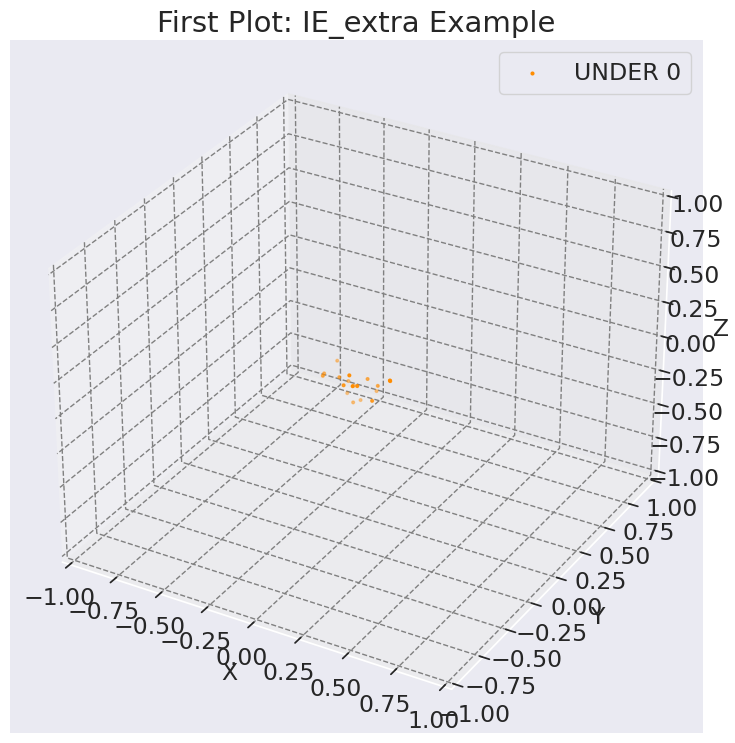

In [13]:
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

under_clusters = IV_IE_dict["UNDER_clusters"]


# UNDER
for idx, (i, cluster_data) in enumerate(under_clusters.items()):
    row_indices = cluster_data["From_test"]
    xs, ys, zs = [], [], []
    for ridx in row_indices:
        x, y, z = test_data[ridx]
        xs.append(x); ys.append(y); zs.append(z)
    ax.scatter(xs, ys, zs, c='darkorange', marker='.',s=15, label=f"UNDER {i}" if idx==0 else "")

ax.set_title("First Plot: IE_extra Example")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
ax.legend()
plt.show()

In [14]:
from EagleEye_v7 import pval_post_equalization
# get the distribution of Upsilon_i^+
under_clusters = IV_IE_dict.get("UNDER_clusters", {})

# Suppose these are your arrays of Upsilon_i^+ for all test points and for the "OVER" subset
data_all = result_dictionary['stats']['Upsilon_i_plus']

all_underdensities = [
    idx 
    for cluster_data in under_clusters.values() 
    for idx in cluster_data.get('From_ref', [])
]

all_eualized_u = [x for x in range(reference_data.shape[0]) if x not in all_underdensities ]

NUMBER_CORES = 10
PARTITION_SIZE = 100


Upsilon_post_IE_u = pval_post_equalization(
    reference_data, 
    test_data, 
    all_eualized_u,
    K_M,
    NUMBER_CORES,
    PARTITION_SIZE
    )

In [15]:

def plot_third_subplot(ax, 
                       Upsilon_i, 
                       null_distribution, 
                       Upsilon_star_plus, 
                       Upsilon_set_equalized, 
                       Upsilon_set_repechage,
                       Upsilon_set_pruned,
                       n_bins=100,
                       legend = True,
                       var_legend = 'X' ):
    """
    Plots a log-log histogram on the provided Axes object using pre-loaded data.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The Axes object on which to plot.
    Upsilon_i : array-like
        Original dataset (e.g. first 50000 rows from column 0).
    null_distribution : array-like
        Dataset after equalization (e.g. all rows from column 1).
    Upsilon_star_plus : float
        Critical threshold value (e.g. first row, column 2).
    Upsilon_set_equalized : array-like
        Null distribution (e.g. first 47019 rows from column 3).
    Upsilon_set_repechage : array-like
        Points recognized as anomalies (e.g. first 2982 rows from column 4).
    n_bins : int, optional
        Number of logarithmically spaced bins (default is 100).
    """
    # -------------------------------
    # 1. Define fixed logarithmically spaced bins based on the Original dataset
    # -------------------------------
    bins = np.logspace(np.log10(np.min(Upsilon_i)),
                       np.log10(np.max(100)),
                       n_bins)

    # -------------------------------
    # 2. Compute histograms and normalize appropriately
    # -------------------------------
    # For the Original dataset, normalize by its own number of elements.
    counts_Upsilon_i, _ = np.histogram(Upsilon_i, bins=bins)
    norm_Upsilon_i = counts_Upsilon_i / len(Upsilon_i)
    
    # For the dataset after equalization, normalize by its own number of elements.
    counts_null_distribution, _ = np.histogram(null_distribution, bins=bins)
    norm_null_distribution = counts_null_distribution / len(null_distribution)
    
    # For the null distribution, normalize by its own number of elements.
    counts_Upsilon_set_equalized, _ = np.histogram(Upsilon_set_equalized, bins=bins)
    norm_Upsilon_set_equalized = counts_Upsilon_set_equalized / len(Upsilon_set_equalized)
    
    # For the anomalies, normalize by the size of the Original dataset.
    counts_Upsilon_set_repechage, _ = np.histogram(Upsilon_set_repechage, bins=bins)
    norm_Upsilon_set_repechage = counts_Upsilon_set_repechage / len(Upsilon_i)
    
    # For the anomalies, normalize by the size of the Original dataset.
    counts_Upsilon_set_pruned, _ = np.histogram(Upsilon_set_pruned, bins=bins)
    norm_Upsilon_set_pruned = counts_Upsilon_set_pruned / len(Upsilon_i)

    # Compute bin centers and widths (for bar plotting)
    bin_centers = np.sqrt(bins[:-1] * bins[1:])  # Geometric mean for log bins.
    bin_widths  = np.diff(bins)                    # Width of each bin.

    # -------------------------------
    # 3. Plotting
    # -------------------------------
    # Set both axes to logarithmic scale.
    ax.set_xscale('log')
    ax.set_yscale('log')

    # Increase tick thickness.
    ax.tick_params(axis='both', which='major', length=8, width=2)
    ax.tick_params(axis='both', which='minor', length=4, width=1.5)

    # Plot Original dataset and anomalies as bars with white edges.
    #ax.bar(bin_centers, norm_Upsilon_i, width=bin_widths, color='silver',
    #       alpha=0.6, edgecolor='white', linewidth=2,
    #       label=r'Flagged anomalous points: $\mathcal{Y}^+$', align='center')
    
        # First 32 bars with a white edge
    ax.bar(bin_centers[:-22], norm_Upsilon_i[:-22], width=bin_widths[:-22],
           color='silver', alpha=0.6, edgecolor='white', linewidth=2,
            align='center')
    if var_legend =='X':
        # The remaining bars with a red edge
        ax.bar(bin_centers[-22:], norm_Upsilon_i[-22:], width=bin_widths[-22:],
               color='silver', alpha=0.6, edgecolor='red', linewidth=2,
               label=r'Flagged anomalous points: $\mathcal{X}^+$',align='center')
        ax.bar(bin_centers, norm_Upsilon_set_repechage, width=bin_widths, color='limegreen',
               alpha=0.6, edgecolor='white', linewidth=2,
               label=r'Anomalies after $rep\hat{e}chage$: $\mathcal{X}_{\alpha}^{\mathrm{anom}}$', align='center')

        ax.bar(bin_centers, norm_Upsilon_set_pruned, width=bin_widths, color='darkgreen',
               alpha=0.6, edgecolor='white', linewidth=2,
               label=r'Pruned set: $\hat{\mathcal{X}}^+$', align='center')    



        # Plot the equalized dataset and null distribution as lines.
        ax.plot(bin_centers, norm_null_distribution, marker='.', color='black',
                label=r'Null distribution')

        ax.bar(bin_centers, norm_Upsilon_set_equalized, width=bin_widths, color='dodgerblue',
               alpha=0.6, edgecolor='white', linewidth=2,
               label=r'Dataset after equalization: $\mathcal{X}^{\mathrm{eq}}$', align='center')   

        # Add a vertical dashed red line at the critical threshold.
        ax.axvline(x=Upsilon_star_plus, color='red', linestyle='--', linewidth=2,
                   label=r'Critical Threshold:$\mathcal{X}_+^{*}$')
    else:
    
    
            # The remaining bars with a red edge
        ax.bar(bin_centers[-22:], norm_Upsilon_i[-22:], width=bin_widths[-22:],
               color='silver', alpha=0.6, edgecolor='red', linewidth=2,
               label=r'Flagged anomalous points: $\mathcal{Y}^+$',align='center')
        ax.bar(bin_centers, norm_Upsilon_set_repechage, width=bin_widths, color='limegreen',
               alpha=0.6, edgecolor='white', linewidth=2,
               label=r'Anomalies after $rep\hat{e}chage$: $\mathcal{Y}_{\alpha}^{\mathrm{anom}}$', align='center')

        ax.bar(bin_centers, norm_Upsilon_set_pruned, width=bin_widths, color='darkgreen',
               alpha=0.6, edgecolor='white', linewidth=2,
               label=r'Pruned set: $\hat{\mathcal{Y}}^+$', align='center')    



        # Plot the equalized dataset and null distribution as lines.
        ax.plot(bin_centers, norm_null_distribution, marker='.', color='black',
                label=r'Null distribution')

        ax.bar(bin_centers, norm_Upsilon_set_equalized, width=bin_widths, color='dodgerblue',
               alpha=0.6, edgecolor='white', linewidth=2,
               label=r'Dataset after equalization: $\mathcal{Y}^{\mathrm{eq}}$', align='center')   

        # Add a vertical dashed red line at the critical threshold.
        ax.axvline(x=Upsilon_star_plus, color='red', linestyle='--', linewidth=2,
                   label=r'Critical Threshold:$\mathcal{Y}_+^{*}$')



    # Set the x and y limits.
    ax.set_xlim([1.5, 100])
    ax.set_ylim([1e-5, 1])

    # Labeling and legend.
    ax.set_xlabel(r'$\mathbf{\Upsilon}_i$')
    
    handles, labels = ax.get_legend_handles_labels()

    # Define the desired order of indices.
    # For example, if the plotting order (and default legend order) is:
    #  0: 'Original dataset'
    #  1: 'Points detected as anomalies'
    #  2: 'Points removed by density equalization'
    #  3: 'Null distribution'
    #  4: 'Dataset after equalization'
    #  5: 'Critical Threshold'
    #
    # and you want the legend to list them in the order:
    # 'Critical Threshold', 'Original dataset', 'Null distribution',
    # 'Dataset after equalization', 'Points removed by density equalization',
    # 'Points detected as anomalies', then your order list would be:
    desired_order = [0, 1, 2, 4, 3, 5 ]

    # Reorder the handles and labels according to the desired order.
    ordered_handles = [handles[i] for i in desired_order]
    ordered_labels = [labels[i] for i in desired_order]

    # Now create the legend with the new ordering.
    if legend:
        ax.legend(ordered_handles, ordered_labels)
    #ax.legend()

In [16]:
def plot_first_subplot(ax, 
                       result_dictionary, 
                       test_data,
                       reference_data,
                       truncated_cmap_reds, 
                       truncated_cmap_purples,
                       qt
                      ):
    
    


    # Plotting reference data using truncated Purples
    idx_plot2 = result_dictionary['stats_reverse']['Upsilon_i_plus'] >= result_dictionary['Upsilon_star_plus'][qt]
    sc2 = axes[1].scatter(
        reference_data[idx_plot2, 0],
        reference_data[idx_plot2, 1],
        reference_data[idx_plot2, 2],
        c=result_dictionary['stats_reverse']['Upsilon_i_plus'][idx_plot2],
        label=r'Flagged anomalous points: $\mathcal{X}^+$',
        cmap=truncated_cmap_purples,  # Use truncated Purples colormap
        alpha=1,
        s=5,
        vmin=result_dictionary['Upsilon_star_plus'][qt]
    )
    colorbar2 = fig.colorbar(sc2, ax=axes[1], orientation='horizontal', fraction=0.05, pad=0.03)
    colorbar2.set_label(r'$\mathbf{\Upsilon}_i(\mathcal{X}^+)$')

    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    ax.set_zlim(-1, 1)
    #axes[0].set_title("$\\Upsilon_i^+ \geq \\Upsilon_*^+$ in Test and Reference ", fontsize=14)
    ax.legend(markerfirst=True, markerscale=3)

In [17]:
qt

0

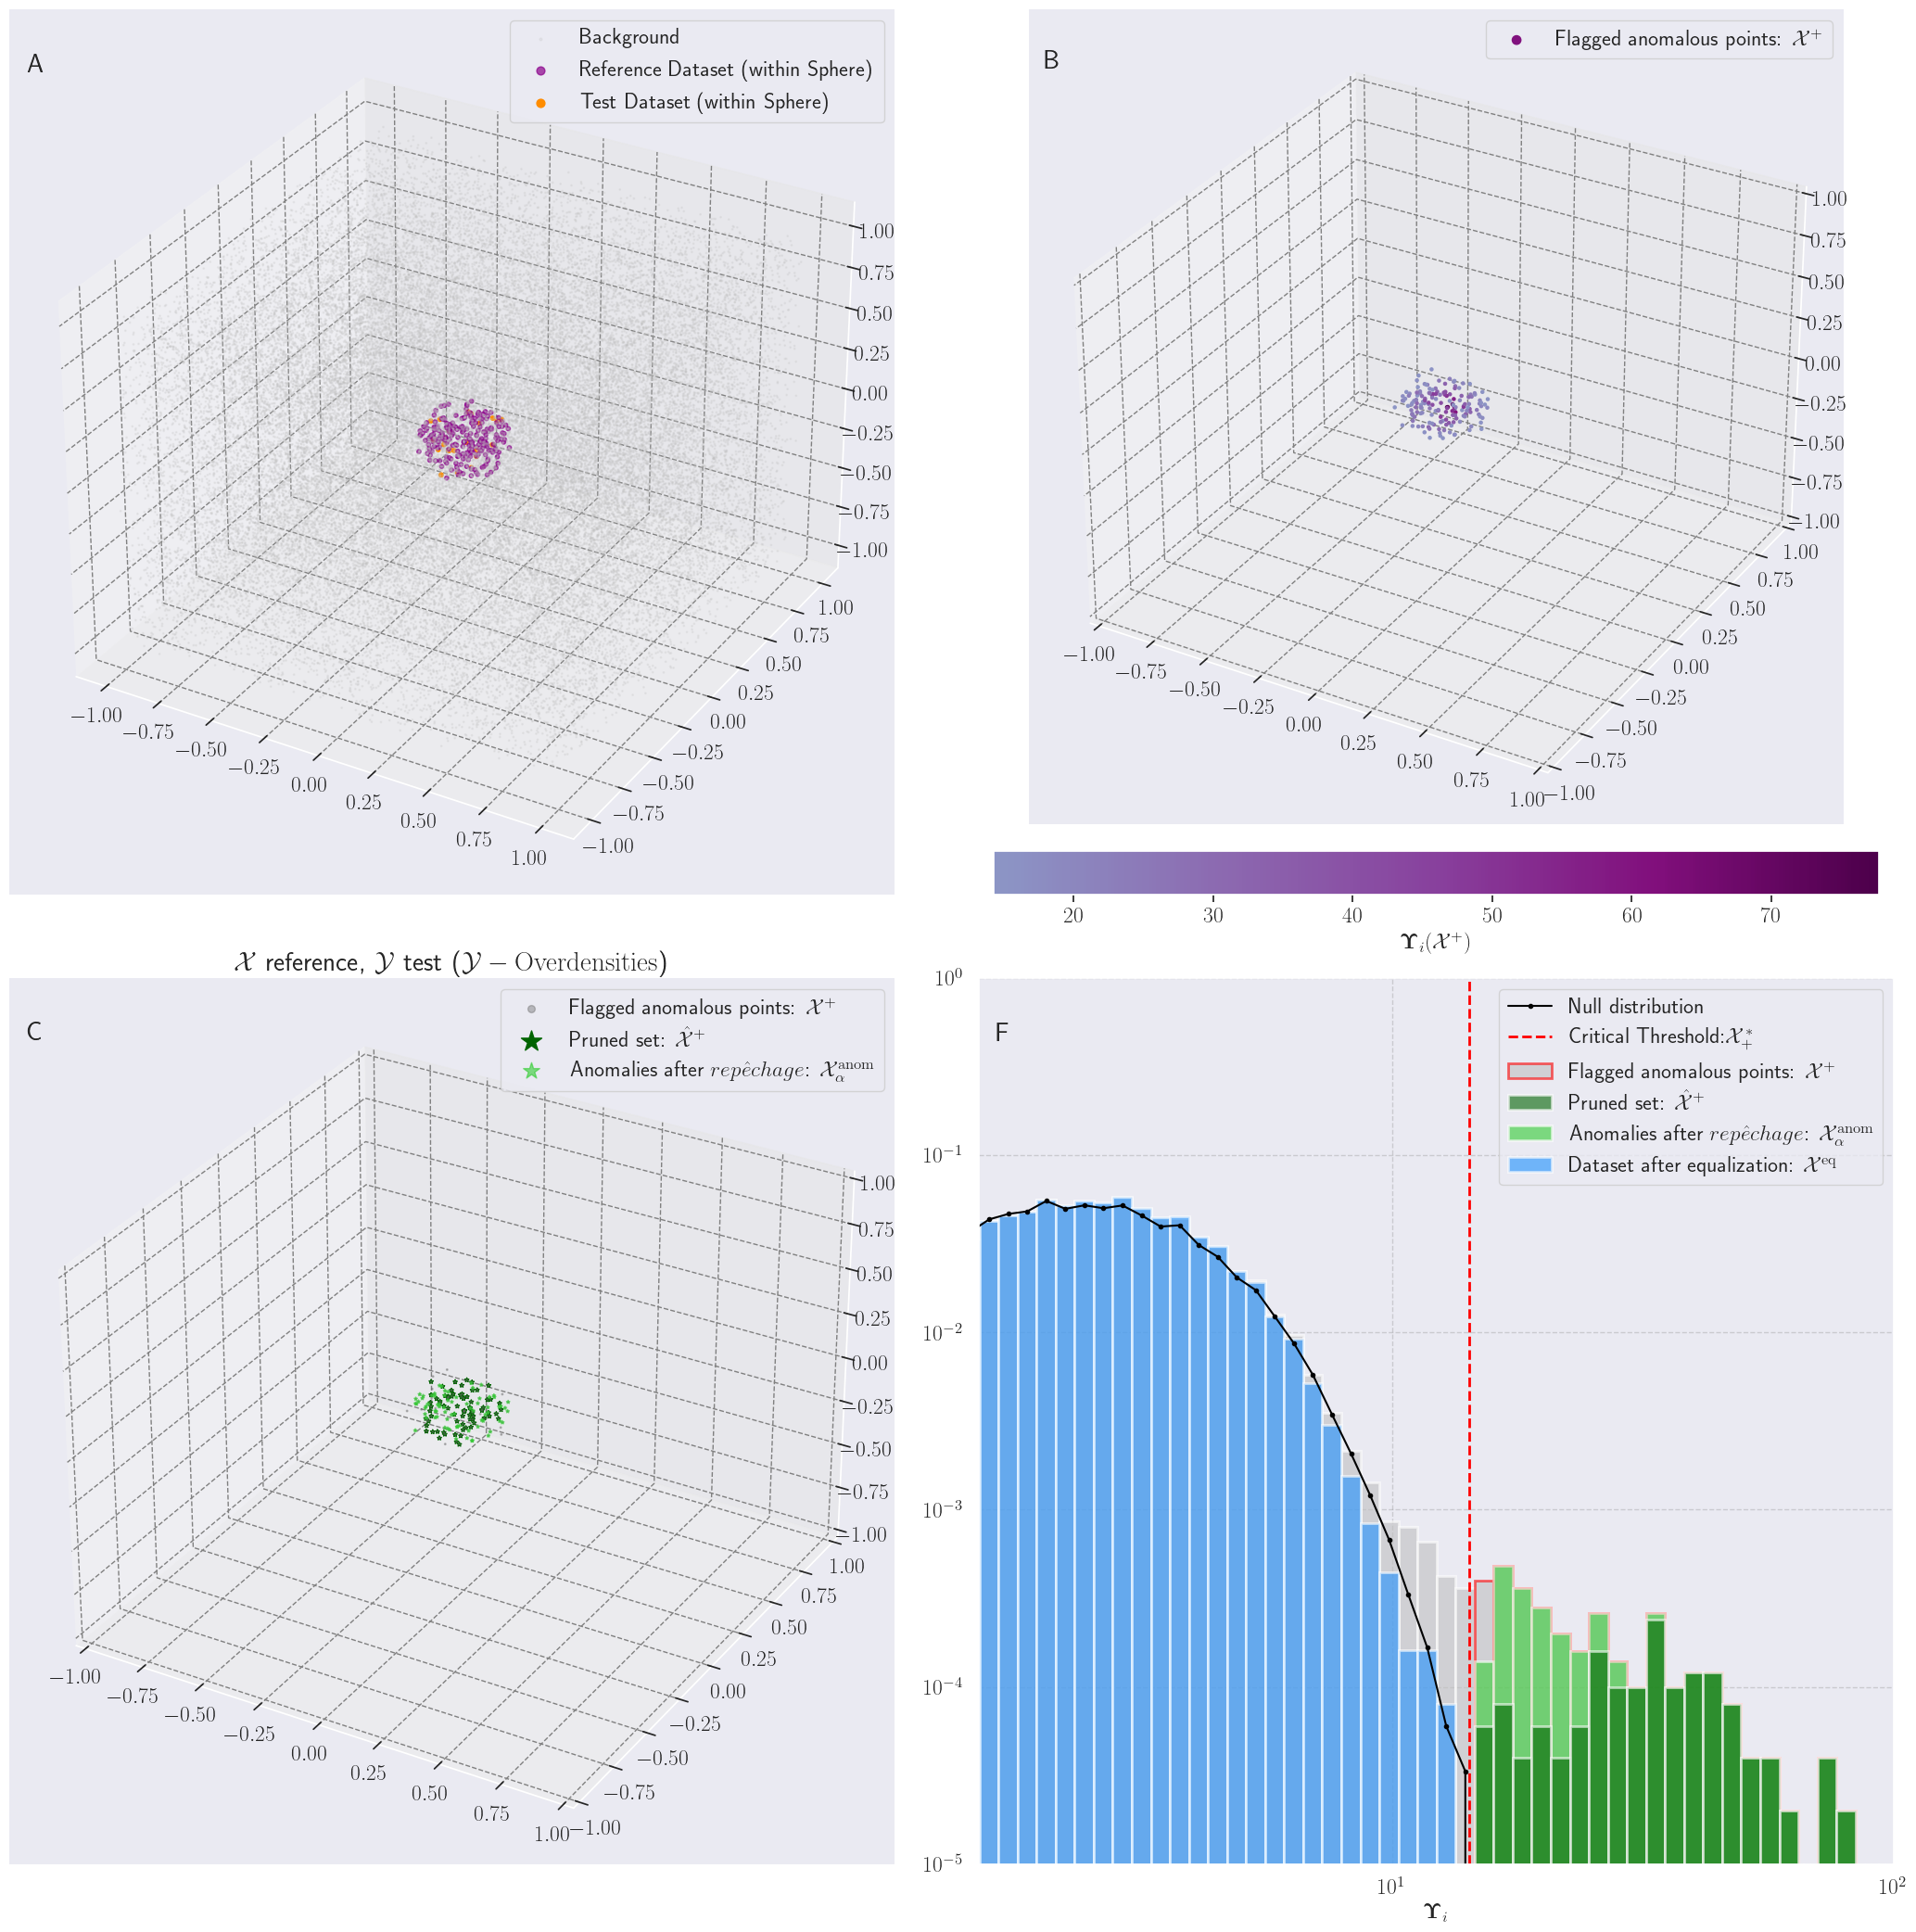

In [29]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['text.usetex'] = True  # Use LaTeX for all text

import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors
from utils_37 import get_shades
import plot_utilities

# --- Define a function to truncate a colormap ---
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    """
    Return a new colormap which is a subset of the given colormap.
    
    Parameters:
        cmap : matplotlib.colors.Colormap
            The original colormap.
        minval : float
            The lower bound of the new colormap (0 to 1).
        maxval : float
            The upper bound of the new colormap (0 to 1).
        n : int
            The number of discrete colors.
    
    Returns:
        new_cmap : matplotlib.colors.LinearSegmentedColormap
            The truncated colormap.
    """
    new_colors = cmap(np.linspace(minval, maxval, n))
    new_cmap = mcolors.LinearSegmentedColormap.from_list(
        f"truncated({cmap.name}, {minval:.2f}, {maxval:.2f})", new_colors)
    return new_cmap

# --- Create truncated versions of 'Reds' and 'Purples' (skipping the first 20%) ---
truncated_cmap_reds = truncate_colormap(plt.get_cmap('Oranges'), minval=0.3, maxval=1.0, n=100)
truncated_cmap_purples = truncate_colormap(plt.get_cmap('BuPu'), minval=0.5, maxval=1.0, n=100)

# -------------------------------------------------------------------------
# Your existing code:
under_clusters = IV_IE_dict.get("UNDER_clusters", {})




underdensities_IE_AG = [
    idx 
    for cluster_data in under_clusters.values() 
    for idx in cluster_data.get('From_ref', [])
]

underdensities_IE = [
    idx 
    for cluster_data in under_clusters.values() 
    for idx in cluster_data.get('IE_extra', [])
]





data_all_u       = result_dictionary['stats_reverse']['Upsilon_i_plus']

data_sub_u_IE_AG = data_all_u[underdensities_IE_AG]
data_sub_u_IE    = data_all_u[underdensities_IE]


# -------------------------------------------------------------------------
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%



















fig = plt.figure(figsize=(21, 21))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 1])

# 3D subplots (ax0, ax1) ...
ax0a = fig.add_subplot(gs[0, 0], projection='3d')
ax0 = fig.add_subplot(gs[0, 1], projection='3d')
ax1 = fig.add_subplot(gs[1, 0], projection='3d')
#ax1b = fig.add_subplot(gs[1, 1], projection='3d')
# 1D distribution subplot
#ax2 = fig.add_subplot(gs[2, 0])
ax3 = fig.add_subplot(gs[1, 1])

# -------------------------------------------------------------------------
# Continue with your plotting code:
axes = [ax0a, ax0, ax1,ax3]

#############################################################################
# Everything below remains as you had it (titles, colorbars, etc.)          #
#############################################################################
#what_ref = reference_data[:-np.array(anomaly_sizes_u).sum(),:]
#what_under = reference_data[-np.array(anomaly_sizes_u).sum():,:]

#ax0a.scatter(what_ref[:,0],what_ref[:,1],what_ref[:,2], c='lightgray', s=5, alpha=0.2, label = r'Background')
#ax0a.scatter(what_under[:,0],what_under[:,1],what_under[:,2], c='darkmagenta', s=15, alpha=1,label = r'Contamination of $\mathcal{X}$ ')
# Scatter plot for points within the ball in reference dataset
ax0a.scatter(reference_data[:, 0], reference_data[:, 1], reference_data[:, 2], s=1, alpha=.2, c='silver',label="Background")

ax0a.scatter(points_reference_ball[:, 0], points_reference_ball[:, 1], points_reference_ball[:, 2], s=10, alpha=.7, c='darkmagenta',label="Reference Dataset (within Sphere)")

# Scatter plot for points within the ball in test dataset
ax0a.scatter(points_test_ball[:, 0], points_test_ball[:, 1], points_test_ball[:, 2], s=10, alpha=1, c='darkorange', label="Test Dataset (within Sphere)")


axes[0].legend( markerscale=2)

plot_first_subplot(ax0, 
                       result_dictionary, 
                       test_data,
                       reference_data,
                       truncated_cmap_reds, 
                       truncated_cmap_purples,
                       qt
                  )
#%%



#%%
silver_under = result_dictionary['stats_reverse']['Upsilon_i_plus']>=result_dictionary['Upsilon_star_plus'][qt]

silver_under = [x for x in silver_under if x not in underdensities_IE_AG]
underdensities_IE_AG = [x for x in underdensities_IE_AG if x not in underdensities_IE]

axes[2].scatter(reference_data[silver_under,0], reference_data[silver_under,1], reference_data[silver_under,2], c='dimgray', label = r'Flagged anomalous points: $X^+$ ', marker='.', s=5, alpha=.4)
axes[2].scatter(reference_data[underdensities_IE_AG,0], reference_data[underdensities_IE_AG,1], reference_data[underdensities_IE_AG,2], c='limegreen',label=r'Pruned set: $\hat{X}^+$', marker='*', s=7, alpha=.6)
axes[2].scatter(reference_data[underdensities_IE,0], reference_data[underdensities_IE,1], reference_data[underdensities_IE,2], c='darkgreen', label=r'Anomalies after $rep\hat{e}chage$: $X_{\alpha}^{\textrm{anom}}$', marker='*', s=11, alpha=1)


axes[2].set_xlim(-1, 1)
axes[2].set_ylim(-1, 1)
axes[2].set_zlim(-1, 1)
handles2, _ = axes[2].get_legend_handles_labels()



#axes[1].legend(['$\\Upsilon_i^+ \geq \\Upsilon_*^+$','Points detected as anomalies','Points removed by density equalization'])
# Get the current legend handles and labels (if any)


# Rearrange the handles so that the last two are swapped.
# This keeps the first handle in place and inverts the order of the second and third.
new_handles2 = [handles2[0], handles2[2], handles2[1]]

# Specify the new legend labels accordingly.
new_labels = [
    r'Flagged anomalous points: $\mathcal{Y}^+$ ',
    r'Pruned set: $\hat{\mathcal{Y}}^+$',
    r'Anomalies after $rep\hat{e}chage$: $\mathcal{Y}_{\alpha}^{\mathrm{anom}}$'
]

new_labels2 = [
    r'Flagged anomalous points: $\mathcal{X}^+$ ',
    r'Pruned set: $\hat{\mathcal{X}}^+$',
    r'Anomalies after $rep\hat{e}chage$: $\mathcal{X}_{\alpha}^{\mathrm{anom}}$'
]

# Apply the new legend with reordered handles and labels.
axes[2].legend(new_handles2, new_labels2, markerscale=5)
# -------------------------------------------------------------------------
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


plot_third_subplot(ax3, 
                   data_all_u, 
                   result_dictionary['Upsilon_i_plus_null'], 
                   result_dictionary['Upsilon_star_plus'][qt], 
                   Upsilon_post_IE_u, 
                   data_sub_u_IE_AG, 
                   data_sub_u_IE,
                   n_bins=100,
                   legend = True,
                   var_legend = 'X')

plt.tight_layout()
# -------------------------------------------------------------------------
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


# Adding labels to each subplot
ax0a.annotate('A', xy=(0.02, 0.95), xycoords='axes fraction',
             fontsize=21, fontweight='bold', va='top', ha='left')


# Adding labels to each subplot
ax0.annotate('B', xy=(0.02, 0.95), xycoords='axes fraction',
             fontsize=21, fontweight='bold', va='top', ha='left')

#ax0.set_title('Candidate anomalous points ')

ax1.annotate('C', xy=(0.02, 0.95), xycoords='axes fraction',
             fontsize=21, fontweight='bold', va='top', ha='left')

ax1b.annotate('D', xy=(0.02, 0.95), xycoords='axes fraction',
             fontsize=21, fontweight='bold', va='top', ha='left')

ax1.set_title('$\mathcal{X}$ reference, $\mathcal{Y}$ test ($\mathcal{Y}-\mathrm{Overdensities}$)')
ax1b.set_title('$\mathcal{Y}$ reference, $\mathcal{X}$ test ( $\mathcal{X}-\mathrm{Overdensities}$)')

ax2.annotate('E', xy=(0.02, 0.95), xycoords='axes fraction',
             fontsize=21, fontweight='bold', va='top', ha='left')

#ax2.set_title('Reference $\mathcal{X}$, test $\mathcal{Y}$ ($\mathcal{Y}-Overdensities$)')


ax3.annotate('F', xy=(0.02, 0.95), xycoords='axes fraction',
             fontsize=21, fontweight='bold', va='top', ha='left')

#ax3.set_title('Reference $\mathcal{Y}$, test $\mathcal{X}$ ( $\mathcal{X}-Overdensities$)')
plt.savefig('vanishing.pdf', format='pdf')
plt.show()


In [19]:
result_dictionary['Upsilon_star_plus'][qt]

14.255456531608704

In [20]:
anomaly_sizes_o = [50, 100, 200, 300, 500, 700, 900]
total_array_size = 50000

# Compute the total number of anomalous points
total_anomaly_points = sum(anomaly_sizes_o)

# The anomalies start at this index in the array
start_index = total_array_size - total_anomaly_points

# Retrieve the indexes for each anomaly group
anomaly_indices_o = []  # This will be a list of lists containing the indices for each anomaly

current_index = start_index
for size in anomaly_sizes_o:
    # The anomaly covers indices from current_index to current_index + size - 1
    indices = list(range(current_index, current_index + size))
    anomaly_indices_o.append(indices)
    # Update the current_index for the next anomaly
    current_index += size

anomaly_sizes_u = [ 100, 300, 700, ]
total_array_size = 50000

# Compute the total number of anomalous points
total_anomaly_points = sum(anomaly_sizes_u)

# The anomalies start at this index in the array
start_index = total_array_size - total_anomaly_points

# Retrieve the indexes for each anomaly group
anomaly_indices_u = []  # This will be a list of lists containing the indices for each anomaly

current_index = start_index
for size in anomaly_sizes_u:
    # The anomaly covers indices from current_index to current_index + size - 1
    indices = list(range(current_index, current_index + size))
    anomaly_indices_u.append(indices)
    # Update the current_index for the next anomaly
    current_index += size
    
    
anomaly_indices_u_back = [[elem + total_array_size for elem in sublist] for sublist in anomaly_indices_u]

In [21]:
anomaly_columns = [r'$\mathcal{Y_{\alpha=0}}$',r'$\mathcal{Y_{\alpha=1}}$',r'$\mathcal{Y_{\alpha=2}}$',r'$\mathcal{Y_{\alpha=3}}$',r'$\mathcal{Y_{\alpha=4}}$',r'$\mathcal{Y_{\alpha=5}}$',r'$\mathcal{Y_{\alpha=6}}$',r'$\mathcal{X_{\alpha=0}}$',r'$\mathcal{X_{\alpha=1}}$',r'$\mathcal{X_{\alpha=2}}$']

anomaly_columns

['$\\mathcal{Y_{\\alpha=0}}$',
 '$\\mathcal{Y_{\\alpha=1}}$',
 '$\\mathcal{Y_{\\alpha=2}}$',
 '$\\mathcal{Y_{\\alpha=3}}$',
 '$\\mathcal{Y_{\\alpha=4}}$',
 '$\\mathcal{Y_{\\alpha=5}}$',
 '$\\mathcal{Y_{\\alpha=6}}$',
 '$\\mathcal{X_{\\alpha=0}}$',
 '$\\mathcal{X_{\\alpha=1}}$',
 '$\\mathcal{X_{\\alpha=2}}$']

In [22]:
import pandas as pd
import numpy as np
from IPython.display import display, HTML, Javascript

# -----------------------------
# Define Statistic Names (Row Labels)
# -----------------------------
stat_names = [
    "Added set:                 ",                      # stat_names[0]
    "Flagged: "+r"$\mathcal{Y}^+$ or $\mathcal{X}^+$",             # stat_names[1]
    "Pruned: "+ r"$\hat{\mathcal{Y}}^+$ or $\hat{\mathcal{X}}^+$ ",  # stat_names[2]
    "Repechage: " + r"$\mathcal{Y}_{\alpha}^{anom}$ or $\mathcal{X}_{\alpha}^{anom}$",  # stat_names[3]
    "Injected: " + r"$\mathcal{Y}_{\alpha}^{inj}$ or $\mathcal{X}_{\alpha}^{inj}$"   # stat_names[4]
]

# Initialize the DataFrames with NaN values
df = pd.DataFrame(np.nan, index=stat_names, columns=anomaly_columns)
df1 = pd.DataFrame(np.nan, index=stat_names, columns=anomaly_columns)

# -----------------------------
# Populate the DataFrames
# -----------------------------
# Combine anomaly sizes for all clusters.
anomaly_sizes_all = anomaly_sizes_o + anomaly_sizes_u

counter = 0
for anomaly in anomaly_columns:
    # Row 0: Injected anomaly size
    df.at[stat_names[0], anomaly] = anomaly_sizes_all[counter]
    df1.at[stat_names[0], anomaly] = anomaly_sizes_all[counter]
    
    if counter < 7:
        # For Overdensities (first 7 columns)
        # stat_names[1]: count of clusters below 50000
        df.at[stat_names[1], anomaly] = len(clusters_plus[counter][clusters_plus[counter] < 50000])
        # stat_names[2]: count from 'IE_extra'
        df.at[stat_names[2], anomaly] = len(IV_IE_dict['OVER_clusters'][counter]['IE_extra'])
        # stat_names[3]: count from 'From_test'
        df.at[stat_names[3], anomaly] = len(IV_IE_dict['OVER_clusters'][counter]['From_test'])
        # stat_names[4]: count from 'From_ref'
        df.at[stat_names[4], anomaly] = len(IV_IE_dict['OVER_clusters'][counter]['From_ref'])
        
        df1.at[stat_names[1], anomaly] = len([x for x in clusters_plus[counter][clusters_plus[counter] < 50000]
                                                if x in anomaly_indices_o[counter]])
        df1.at[stat_names[2], anomaly] = len([x for x in IV_IE_dict['OVER_clusters'][counter]['IE_extra']
                                                if x in anomaly_indices_o[counter]])
        df1.at[stat_names[3], anomaly] = len([x for x in IV_IE_dict['OVER_clusters'][counter]['From_test']
                                                if x in anomaly_indices_o[counter]])
        df1.at[stat_names[4], anomaly] = 0
    else:
        # For Underdensities (last 3 columns; adjust index by subtracting 7)
        idx = counter - 7
        # stat_names[1]: count of clusters with values >= 50000
        df.at[stat_names[1], anomaly] = len(clusters_minus[idx][clusters_minus[idx] >= 50000])
        # stat_names[2]: count from 'IE_extra'
        df.at[stat_names[2], anomaly] = len(IV_IE_dict['UNDER_clusters'][idx]['IE_extra'])
        # stat_names[3]: count from 'From_ref'
        df.at[stat_names[3], anomaly] = len(IV_IE_dict['UNDER_clusters'][idx]['From_ref'])
        # stat_names[4]: count from 'From_test'
        df.at[stat_names[4], anomaly] = len(IV_IE_dict['UNDER_clusters'][idx]['From_test'])
        
        df1.at[stat_names[1], anomaly] = len([x for x in clusters_minus[idx][clusters_minus[idx] >= 50000]
                                               if x in anomaly_indices_u_back[idx]])
        df1.at[stat_names[2], anomaly] = len([x for x in IV_IE_dict['UNDER_clusters'][idx]['IE_extra']
                                               if x in anomaly_indices_u[idx]])
        df1.at[stat_names[3], anomaly] = len([x for x in IV_IE_dict['UNDER_clusters'][idx]['From_ref']
                                               if x in anomaly_indices_u[idx]])
        df1.at[stat_names[4], anomaly] = 0
        
    counter += 1

# -----------------------------
# Combine the DataFrames into One
# -----------------------------
# Create a new DataFrame where each cell shows the value from df
# with the corresponding value from df1 in parentheses.
combined_df = pd.DataFrame(index=stat_names, columns=anomaly_columns)

for row in stat_names:
    for col in anomaly_columns:
        val_df = df.at[row, col]
        val_df1 = df1.at[row, col]
        if pd.notnull(val_df) and pd.notnull(val_df1):
            combined_df.at[row, col] = f"{int(val_df)} ({int(val_df1)})"
        elif pd.notnull(val_df):
            combined_df.at[row, col] = f"{int(val_df)}"
        elif pd.notnull(val_df1):
            combined_df.at[row, col] = f"({int(val_df1)})"
        else:
            combined_df.at[row, col] = ""

# -----------------------------
# Display the Combined Table
# -----------------------------
html_table = combined_df.to_html(escape=False)
display(HTML(html_table))

# (Optional) Force MathJax to re-typeset the page so that LaTeX in the table is rendered properly.
display(Javascript("MathJax.Hub.Queue(['Typeset', MathJax.Hub]);"))


TypeError: '<' not supported between instances of 'list' and 'int'

In [ ]:

def MAS_estimate(dict,IVIE,mixed_samples, reference_samples,thresh=14):
    over_clusters  = IVIE["OVER_clusters"] # Need to generate as a function of Upsilon_star
    lenSo          =  len(np.concatenate([over_clusters[idx]['From_test'] for idx in list(over_clusters.keys())]))
    lenBo          =  len(np.concatenate([over_clusters[idx]['From_ref'] for idx in list(over_clusters.keys())]))
    lenWo          =  len(np.concatenate([over_clusters[idx]['IE_extra'] for idx in list(over_clusters.keys())]))
    S_B           = lenWo / np.sqrt(lenSo - lenWo)
    n2            = len(mixed_samples) 
    n1            = len(reference_samples)
    SoUpsilons    =  np.concatenate([dict['stats']['Upsilon_i_plus'][over_clusters[idx]['From_test']] for idx in list(over_clusters.keys())])
    print("Upsilon_xi = ", min(SoUpsilons))
    # ----------------------------
    # Eqn rom draft
    S_B = lenSo  - (lenBo/n1) *  (n2 - lenWo)
    S_B = S_B / np.sqrt(S_B)
    return [S_B,min(SoUpsilons)]

def MAS(dict,lables_mix,thresh=14):
    l   = lables_mix#dict['stats']['lables_mix']
    s   = dict['stats']['Upsilon_i_plus'][(dict['stats']['Upsilon_i_plus']>thresh) & (l==1)]
    b   = dict['stats']['Upsilon_i_plus'][(dict['stats']['Upsilon_i_plus']>thresh) & (l==0)]
    return len(s)/np.sqrt(len(b))

def S_SB_estimate(dict,IVIE,thresh=14):
    over_clusters  = IVIE["OVER_clusters"] # Need to generate as a function of Upsilon_star
    lenSo          =  len(np.concatenate([over_clusters[idx]['From_test'] for idx in list(over_clusters.keys())]))
    lenBo          =  len(np.concatenate([over_clusters[idx]['From_ref'] for idx in list(over_clusters.keys())]))
    lenWo          =  len(np.concatenate([over_clusters[idx]['IE_extra'] for idx in list(over_clusters.keys())]))
    n2            = len(dict['stats']['mixed_samples']) 
    n1            = len(dict['stats']['reference_samples'])
    S_SB = lenSo  - (lenBo/n1) *  (n2 - lenWo)
    S_SB = S_SB / lenSo
    return S_SB

def S_SB(dict,thresh=14):
    l   = dict['stats']['lables_mix']
    s = dict['stats']['Upsilon_i_plus'][(dict['stats']['Upsilon_i_plus']>thresh) & (l==1)]
    b = dict['stats']['Upsilon_i_plus'][(dict['stats']['Upsilon_i_plus']>thresh) & (l==0)]
    return len(s)/(len(s) + len(b))

In [ ]:
MAS_estimate(result_dictionary,IV_IE_dict,reference_data, test_data,result_dictionary['Upsilon_star_plus'][qt])

In [ ]:

# Define anomaly sizes
anomaly_sizes_o = [50, 100, 200, 300, 500, 700, 900]
total_array_size = 50000

# Compute the number of zeros and ones
num_zeros = total_array_size - np.sum(anomaly_sizes_o)
num_ones = np.sum(anomaly_sizes_o)

# Create a single list (or array) with first all zeros, then all ones
lables_mix = np.concatenate([np.zeros(num_zeros), np.ones(num_ones)])

MAS(result_dictionary,lables_mix,result_dictionary['Upsilon_star_plus'][qt])

In [ ]:
Ups_i_p_navy               = data_all
null_green                 = result_dictionary['Upsilon_i_plus_null']
Ups_s_p_red                = result_dictionary['Upsilon_star_plus'][0]
Ups_i_p_post_IE_magenta    = Upsilon_post_IE
Ups_i_p_post_IE_AG_gold    = data_sub

In [ ]:
import pandas as pd

# Suppose you have the following data:
Ups_i_p_navy = data_all
null_green = result_dictionary['Upsilon_i_plus_null']
Ups_s_p_red = result_dictionary['Upsilon_star_plus'][1]
Ups_i_p_post_IE_magenta = Upsilon_post_IE
Ups_i_p_post_IE_AG_gold = data_sub

# Create a DataFrame from the vectors. 
# pd.Series(...) ensures each list/array is converted to a column with flexible length.
df = pd.DataFrame({
    'Ups_i_p_navy': pd.Series(Ups_i_p_navy),
    'null_green': pd.Series(null_green),
    'Ups_s_p_red': pd.Series(Ups_s_p_red),
    'Ups_i_p_post_IE_magenta': pd.Series(Ups_i_p_post_IE_magenta),
    'Ups_i_p_post_IE_AG_gold': pd.Series(Ups_i_p_post_IE_AG_gold)
})

# Save to CSV
df.to_csv('pannelC.csv', index=False)
print("Data saved to my_vectors.csv")

In [ ]:
Ups_s_p_red